# Khaan Bank Customer risk prediction

Using fast.ai tabular modelling to predict Khaan bank customers' risk type

## Import and Load packages

In [3]:
!pip install -Uqq fastai --upgrade
!pip install -Uqq fastcore --upgrade
!pip install -Uqq kaggle --upgrade!

     |████████████████████████████████| 194kB 6.0MB/s 
     |████████████████████████████████| 12.8MB 264kB/s 
     |████████████████████████████████| 61kB 5.9MB/s 
     |████████████████████████████████| 776.8MB 17kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --upgrade!


In [4]:
import fastai
import fastcore
print('Fast.ai version:', fastai.__version__)
print('Fastcore version:', fastcore.__version__)

Fast.ai version: 1.0.61
Fastcore version: 1.3.19


In [7]:
from fastai.tabular.all import *
import pandas as pd 
import numpy as np

In [62]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Load dataset
##### Found this dataset from github. 

In [63]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/khan/Khan.csv')
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


## Data cleaning
##### We can see Nan values and other unuseful columns so that we have to drop those. 

In [65]:
df.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [66]:
df= df.dropna()

In [67]:
df.isnull().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

In [68]:
df.dtypes

Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object

In [71]:
df=df.reset_index()

In [72]:
df=df.drop(['index'],axis=1)

In [73]:
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,22,female,2,own,little,moderate,5951,48,radio/TV,bad
1,45,male,2,free,little,little,7882,42,furniture/equipment,good
2,53,male,2,free,little,little,4870,24,car,bad
3,35,male,3,rent,little,moderate,6948,36,car,good
4,28,male,3,own,little,moderate,5234,30,car,bad
...,...,...,...,...,...,...,...,...,...,...
517,48,male,1,own,little,moderate,1743,24,radio/TV,good
518,30,male,3,own,little,little,3959,36,furniture/equipment,good
519,40,male,3,own,little,little,3857,30,car,good
520,23,male,2,free,little,little,1845,45,radio/TV,bad


In [75]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
# If Risk = 0 bad or Risk = 1 good 
df['Risk'] = labelencoder.fit_transform(df['Risk'])
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,22,female,2,own,little,moderate,5951,48,radio/TV,0
1,45,male,2,free,little,little,7882,42,furniture/equipment,1
2,53,male,2,free,little,little,4870,24,car,0
3,35,male,3,rent,little,moderate,6948,36,car,1
4,28,male,3,own,little,moderate,5234,30,car,0
...,...,...,...,...,...,...,...,...,...,...
517,48,male,1,own,little,moderate,1743,24,radio/TV,1
518,30,male,3,own,little,little,3959,36,furniture/equipment,1
519,40,male,3,own,little,little,3857,30,car,1
520,23,male,2,free,little,little,1845,45,radio/TV,0


## Build Dataloaders

The dataloaders needs to know which features are continuous and which are categorical. There is a convenient method `cont_cat_split` that does this for us. These columns will be used to determine how to transform the data.

Just like images, Fast.ai has a feature to do preprocessing automatically. The `procs` argument is used to tell the dataloaders what preprocessing to do. 

Neural network perform better if the data is normalized. Also, we need to ensure NaN values are filled, and that the categorical features are encoded. We can specify the preprocessing steps as such.

In [76]:
cont, cat = cont_cat_split(df, 1, dep_var='Risk')
procs = [Categorify, FillMissing, Normalize]

We need to tell the dataloaders which rows will be used for the validation set. I used a random sampler built into Pandas and grabbed the indexes. 

In [77]:
valid_idx = df.sample(frac=0.1, random_state=42).index.values

In [128]:
path = Path('/content/drive/MyDrive/Colab Notebooks/khan')
Path.BASE_PATH = path
path.is_absolute()

True

Now we can build our dataloaders!

In [81]:
dls = TabularDataLoaders.from_df(df, 
                                 path, 
                                 procs=procs, 
                                 cat_names=cat, 
                                 cont_names=cont, 
                                 y_names="Risk", 
                                 valid_idx=valid_idx, 
                                 bs=64)

In [82]:
dls.show_batch()

,Sex,Housing,Saving accounts,Checking account,Purpose,Age,Job,Credit amount,Duration,Risk
0,male,rent,little,little,business,36.000000,2.000000e+00,7297.000158,60.000001,0.0
1,male,own,little,moderate,radio/TV,33.000000,2.000000e+00,6402.999899,24.000000,1.0
2,male,own,little,moderate,car,30.000000,2.000000e+00,1055.999998,18.000000,0.0
3,female,rent,little,moderate,car,26.000000,-1.617087e-08,1777.999949,15.000000,0.0
4,female,rent,quite rich,moderate,radio/TV,23.000000,-1.617087e-08,3758.000014,24.000000,1.0
5,male,free,little,moderate,car,55.000000,3.000000e+00,9283.000025,41.999999,1.0
6,male,free,little,little,car,34.000000,3.000000e+00,2910.000019,24.000000,1.0
7,female,rent,little,little,furniture/equipment,20.000000,2.000000e+00,1281.999984,12.000000,0.0
8,male,free,little,little,car,39.000000,3.000000e+00,3248.999999,35.999999,1.0
9,male,own,quite rich,moderate,radio/TV,66.000001,1.000000e+00,765.999942,12.000000,0.0


By default Fast.ai uses 2 hidden layers, with 200 and 100 activations. With a larger dataset i will get better results with larger activation sizes (500 and 250). But in this situation we have a smaller dataset so i reduced layers.

In [95]:
learn = tabular_learner(dls, metrics=mse, layers=[200,100])

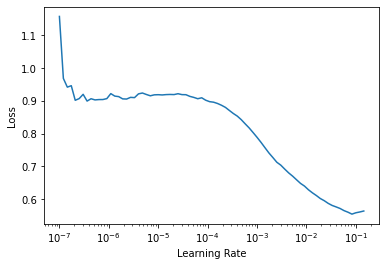

In [96]:
lr_min, lr_steep = learn.lr_find()

In [97]:
learn.fit_one_cycle(5, lr_min)

epoch,train_loss,valid_loss,mse,time
0,0.555147,0.405504,0.405504,00:00
1,0.418798,0.374921,0.374921,00:00
2,0.356803,0.332092,0.332092,00:00
3,0.308997,0.288936,0.288936,00:00
4,0.274421,0.273999,0.273999,00:00


Result shows us that our model works with 27% loss rate which means our accuracy is 73%.